In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t

%matplotlib inline

# Labs 4 and 5

### The effect of mathematical computations and board operating temperature.

<br>Derek Halliwell
<br>Holden Gordon

**1. Devise a hypothesis and state the relevant null and alternative hypothesis.**
<br><br>$h_{0}$: The number of iterations, operation type, and length of cool-down time have no effect on PYNQ board operating temperature.
<br>$h_{1}$: The number of iterations, operation type, and length of cool-down time does have an effect on PYNQ board operating temperature.


**2. Design an experiment to test your hypothesis for multiple linear regression with predictors X1, X2, ..,Xn and response Y. Set up your experiment using two or more sensors with the PYNQ board. Collect data from the sensors and store in a CSV file. Decide the number of observations and duration over which the data will be collected.**

We will measure the operating temperature of the PYNQ board when performing two complex mathematical operations for various large numbers. The encoding of operations is as follows:


| Operation |  Encoding  |
|------|------|
| Largest Prime Factor | 0 | 
| Sieve Of Eratosthenes | 1 |

Our goal is to measure operating temperature of the PYNQ board after performing computationally-heavy mathematical operations on large numbers. At the beginning of each operation, a cool-down period of various sizes will occur.

### Experiment Overview:

1) Let board cool
<br>2) Perform computations on large number
<br>3) Measure temperature of FPGA


In [12]:
train = pd.read_csv('prelim_data_200.csv')
train = train.rename({'Unnamed: 0':'trial_number'},axis=1)

train.head()

,trial_number,temperature,n,cooldown_time,operation
0,0,37.96875,1000000,5,0
1,1,38.00000,10000000,2,0
2,2,37.96875,100000,5,1
3,3,37.93750,1000000,2,0
4,4,37.93750,10000,1,1


**3. Perform a multiple linear regression with predictors X1, X2,..., Xn and response Y. Is there a statistically significant association between X1, X2,...,Xn and Y?**


In [3]:
target = 'temperature'

formula = target + '~' + '+'.join(col for col in train.columns if col != target)

lm = smf.ols(formula=formula,data=train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     123.9
Date:                Thu, 23 May 2019   Prob (F-statistic):           9.44e-46
Time:                        15:54:02   Log-Likelihood:                 197.42
No. Observations:                 150   AIC:                            -384.8
Df Residuals:                     145   BIC:                            -369.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        37.9601      0.017   2272.125      0.000      37.927      37.993
trial_number      0.0028      0.000     21.763      0.000       0.003       0.003
n             -1.142e-09   1.33e-09     -0.858      0.392   -3.77e-09    1.49e-09
cooldown_time     0.0002      0.003      0.059      0.953      -0.006       0.006
operation         0.0101      0.011      0.928      0.355      -0.011       0.031
==============================================================================
Omnibus:                        3.643   Durbin-Watson:                   0.235
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                3.648
Skew:                          -0.375   Prob(JB):                        0.161
Kurtosis:                       2.853   Cond. No.                     1.59e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**4. Create the following diagnostic plots of the linear regression fit:
<br>(a) Influence plot
<br>(b) Pairwise plot
<br>(c) Studentized residual vs predicted response
<br>(d) QQ plot for residuals**

Are there any problems with the fit? Are there any unusually large outliers? Are there any observations with unusually high leverage? Is there a non-linear association between any of the predictors and response? Is heteroscedasticity present in the model?



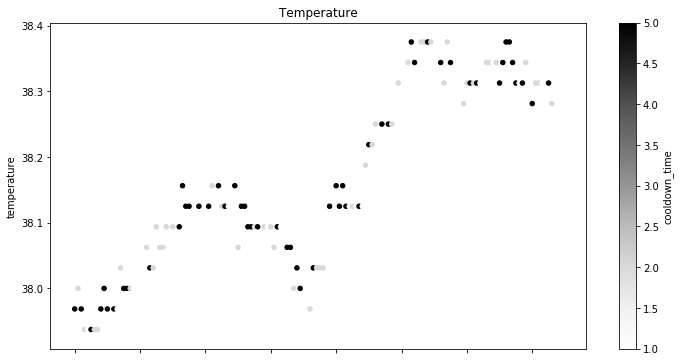

In [40]:
train.plot.scatter(x='trial_number',
                   y='temperature',
                   title='Temperature',
                   figsize=(12,6),
                   c='cooldown_time',);

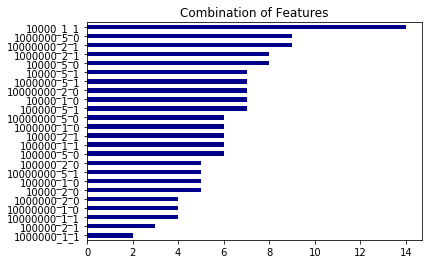

In [56]:
# combinations of n, cool-down time, and operations
train['concat'] = train[['n','cooldown_time','operation']].apply(lambda x: '_'.join(str(col) for col in x),axis=1)

train['concat'].value_counts()[::-1].plot.barh(color='darkblue',title='Combination of Features');

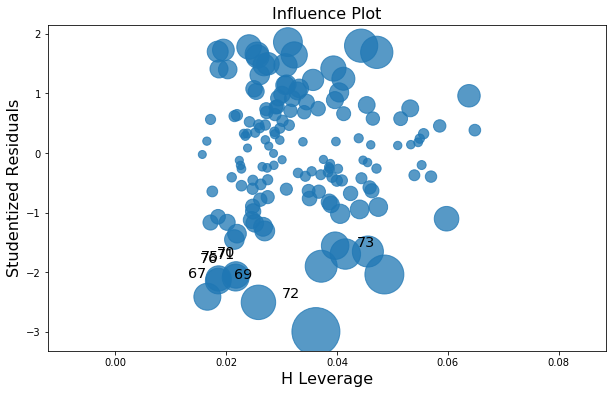

In [5]:
# a) Influence plot
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(lm, ax=ax, criterion="cooks")

We see many points that significantly impact our regression. A potential cause could large numbers that we operated on and the variation within that column.

In [23]:
# Observation 72
train.loc[70:73]

,trial_number,temperature,n,cooldown_time,operation
70,70,38.03125,100000,1,1
71,71,38.03125,100000,1,1
72,72,37.96875,10000000,2,1
73,73,38.03125,10000000,5,1


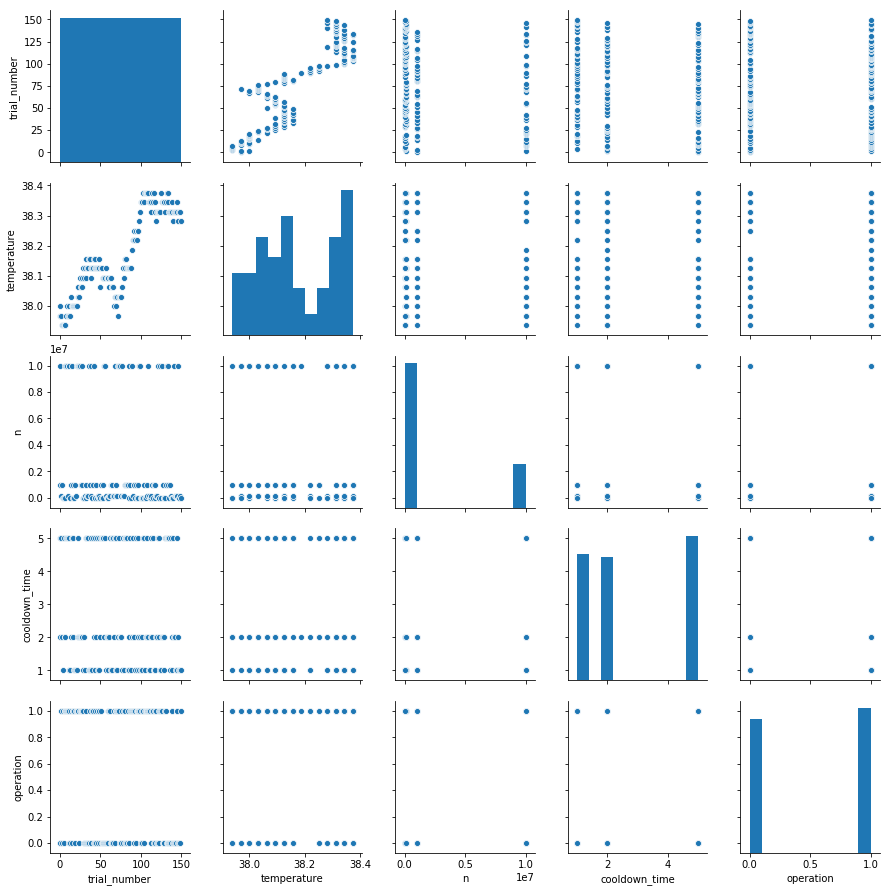

In [6]:
# (b) Pairwise plot 
sns.pairplot(train);


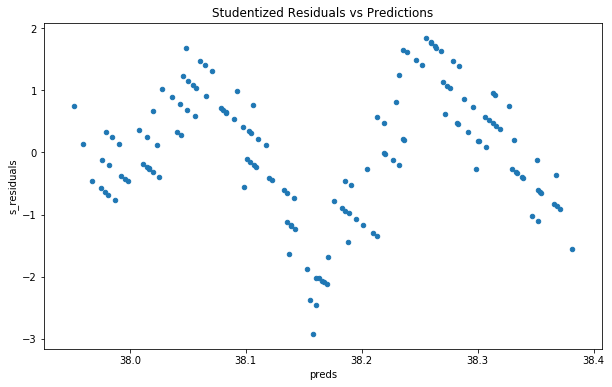

In [7]:
# (c) Studentized residual vs predicted response
infl = lm.get_influence()

train['preds'] = lm.predict(train.drop('temperature',axis=1))
train['leverage'] = infl.hat_matrix_diag
train['s_residuals'] = infl.resid_studentized_internal

train.plot.scatter(x='preds',
                   y='s_residuals',
                   title='Studentized Residuals vs Predictions',
                   figsize=(10,6));

There is a clear pattern here, suggesting that there is an issue with our experiment design. Our results seem to be highly correlated with time. It could be that we are not giving the board enough time to cool down between trials.

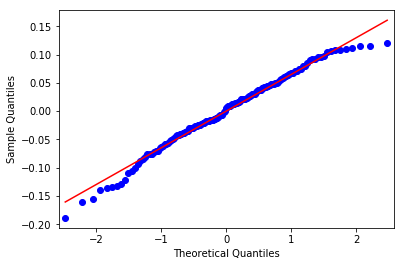

In [8]:
# (d) QQ plot for residuals
fig = sm.qqplot(lm.resid,line='s')


The QQ plot suggests that the residuals are normally distributed. The regression does relatively well mainly because of the trial number feature. This suggests that the temperature is largely a function of time.

**5. Create three forecasts using your model. Comment on how the results from your model compare with observed results.**

In [17]:
test_data = train.loc[:2,['trial_number','n','cooldown_time','operation']]

test = pd.DataFrame(test_data)
test['predicted'] = lm.predict(test)

In [20]:
observed = train[['temperature']].loc[:2]

test = test.merge(observed.rename({'temperature':'observed'},axis=1),
                  left_index=True,
                  right_index=True)

test['difference'] = test['predicted'] - test['observed']
test

,trial_number,n,cooldown_time,operation,predicted,observed,difference
0,0,1000000,5,0,37.959855,37.96875,-0.008895
1,1,10000000,2,0,37.951778,38.00000,-0.048222
2,2,100000,5,1,37.976462,37.96875,0.007712


We see that the predicted values are nearly identical to the observed values. This is likely caused by the temperatures being measured early in the experiment. Possible next steps include allowing longer cool-down times (measured in minutes instead of seconds). However, this will drastically increase data collection time. There could also be internal aspects that are affecting the FPGA board. Having a better understanding of how the board assigns resources to FPGA operations would help us brainstorm more features to include in our regression.